In [40]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
# from functools import reduce
import os
from math import sin, cos
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

PATH = '../input/'
os.listdir(PATH)

['camera.zip',
 'car_models.zip',
 'car_models_json.zip',
 'predictions.csv',
 'sample_submission.csv',
 'test_images.zip',
 'test_masks.zip',
 'train.csv',
 'train_images',
 'train_images.zip',
 'train_masks',
 'train_masks.zip']

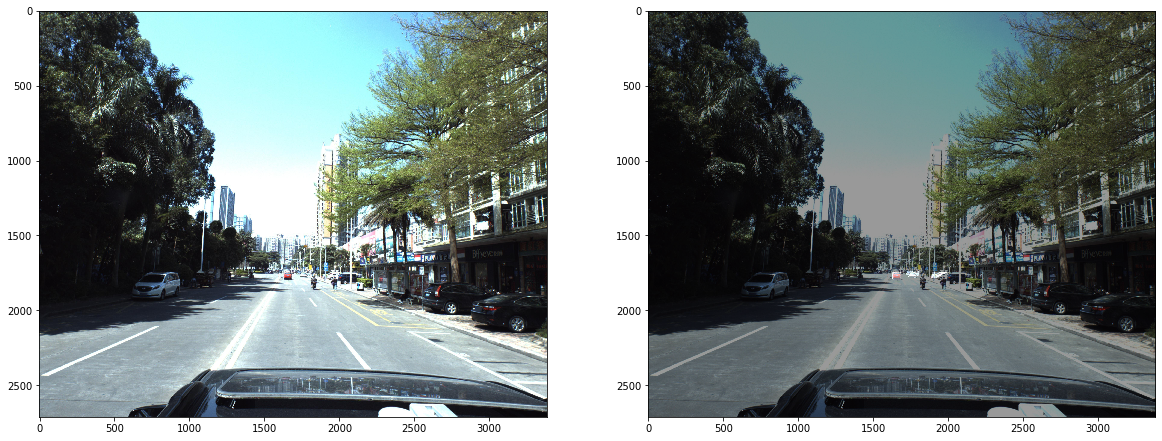

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
img = cv2.imread(PATH + 'train_images/ID_8a6e65317.jpg') #ID_3c2fbeb77
img = np.array(img[:, :, ::-1])
img_mask = cv2.imread(PATH + 'train_masks/ID_8a6e65317.jpg')
ax[0].imshow(img)

ax[1].imshow(img)
ax[1].imshow(img_mask, alpha = 0.4)
plt.show()

In [42]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head(5)

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


In [43]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [44]:
inp = train['PredictionString'][0]
# print('Example input:\n', inp)
# print()
# print('Output:\n', str2coords(inp))
pd.DataFrame(str2coords(inp))

,id,yaw,pitch,roll,x,y,z
0,16,0.254839,-2.57534,-3.10256,7.96539,3.20066,11.0225
1,56,0.181647,-1.46947,-3.12159,9.60332,4.66632,19.3390
2,70,0.163072,-1.56865,-3.11754,10.39000,11.22190,59.7825
3,70,0.141942,-3.13950,3.11969,-9.59236,5.13662,24.7337
4,46,0.163068,-2.08578,-3.11754,9.83335,13.26890,72.9323


Let us take a look at the training data column distributions and any possible correlations.

1. X / Y / Z values are most concentrated near 0 (close to the camera), while there are a few points that are very far from the camera.
2. Roll (rotation around X) and Pitch (roation around Y) are distributed between  π  and - π  (Complete 360 degree rotations allowed around X and Y).
3. Yaw (rotation around Z) seem to be more contrained, which makes sense as cars cannot be completely flipped up-side down on the road side

Assuming...
* X direction approximately corresponds to the direction perpendicular to the road from left to right. Left side of the camera is negative X and right side of the camera is likely positive X.
* Z direction seems to correspond to the direction of the road
* Y direction seems to correspond to the vertical direction (perpendicular to the plane of the road)

In [45]:
def imgread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1]) # what does this do?
    return img

In [46]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

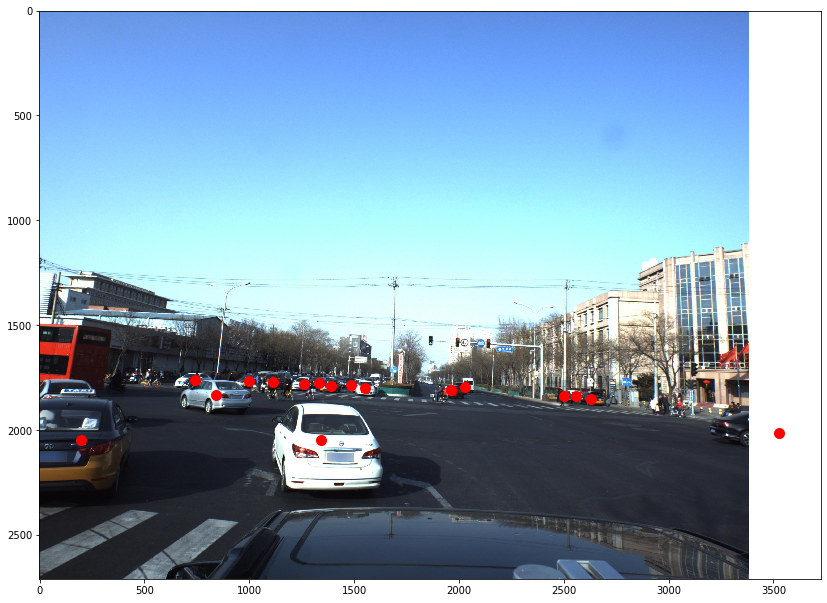

In [47]:
plt.figure(figsize=(14,14))
plt.imshow(imgread(PATH + 'train_images/' + train['ImageId'][2217] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][2217]), color='red', s=100);

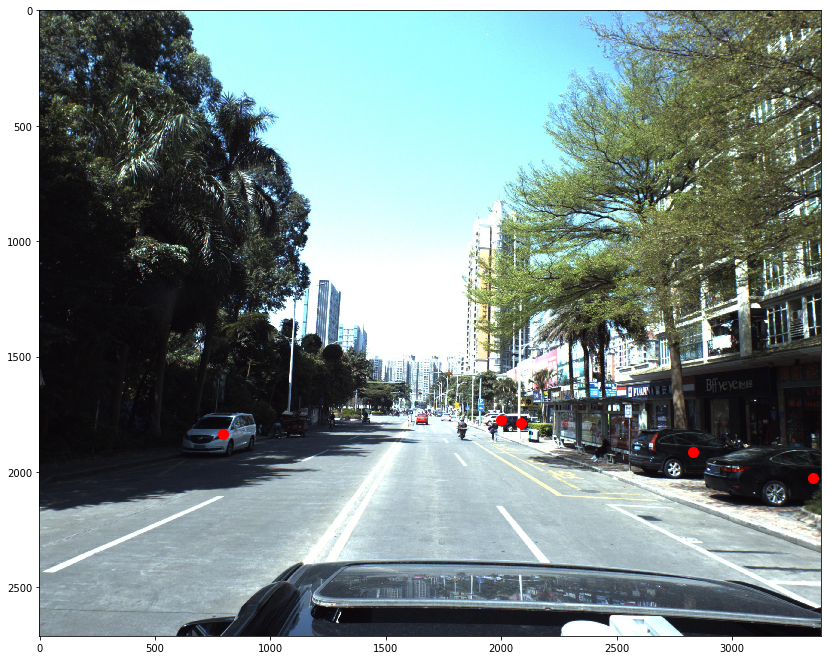

In [48]:
plt.figure(figsize=(14,14))
plt.imshow(imgread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][0]), color='red', s=100);

In [49]:
# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    '''
    Input: Euler Angles
    Output: Rotation Matrix
    '''
    # Rx(pitch) Ry(yaw) Rz(roll)
    Rx = np.array([[1, 0, 0],
                   [0, cos(pitch), -sin(pitch)],
                   [0, sin(pitch), cos(pitch)]])
    Ry = np.array([[cos(yaw), 0, sin(yaw)],
                   [0, 1, 0],
                   [-sin(yaw), 0, cos(yaw)]])
    Rz = np.array([[cos(roll), -sin(roll), 0],
                   [sin(roll), cos(roll), 0],
                   [0, 0, 1]])
    return np.dot(np.dot(Ry, Rx), Rz)

In [50]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

In [51]:
def visualize(img, coords):
    # mean value of all type of car's dimension
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

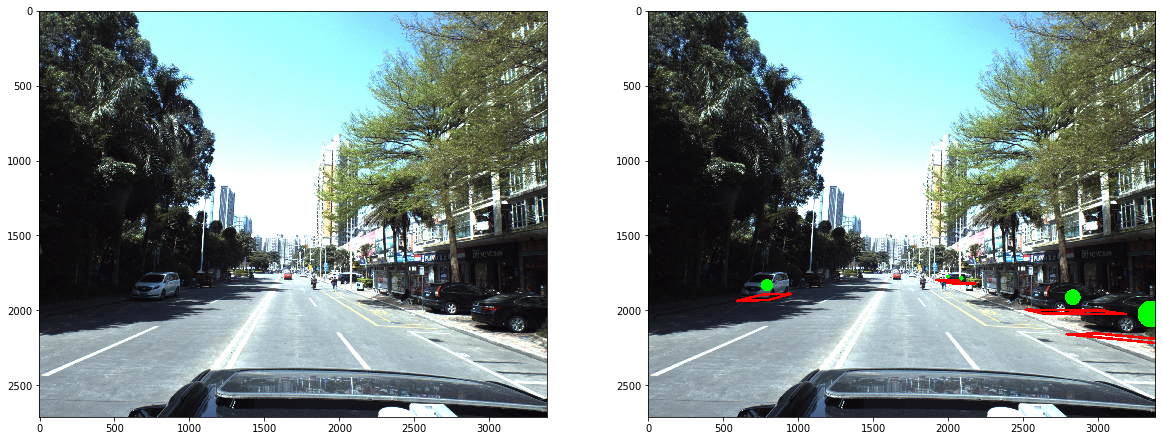

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(20,20))
img = imgread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg')
axes[0].imshow(img)
img_vis = visualize(img, str2coords(train['PredictionString'][0]))
axes[1].imshow(img_vis)
plt.show()